# Homework 5 Juan Mejia

# 1.a

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
file_path = '/Users/juanjo/Library/CloudStorage/OneDrive-UniversityofOklahoma/2024 Fall/Systems Optimization/Homeworks/Homework 5/HW 5 Juan Mejia.xlsx'
df = pd.read_excel(file_path)
# Display the first few rows of the dataframe
df.style

,Company ID,Cash USD,Publicity,Workers,Inventory Management,Revenue USD
0,1,3239,33,6,25,3449
1,2,1481,26,2,13,1877
2,3,100,24,9,12,1242
3,4,447,20,9,14,1080
4,5,1126,35,3,14,1295
5,6,813,44,6,12,1549
6,7,2116,25,9,13,3350
7,8,1181,48,5,16,1285
8,9,1017,33,4,20,4859
9,10,2406,27,8,16,4215


In [9]:
# Extract relevant columns
inputs_outputs = df[['Company ID','Cash USD','Publicity','Workers', 'Inventory Management', 'Revenue USD']]

# Sooners Inc. (Company ID 18) data
sooners_inc = inputs_outputs[inputs_outputs['Company ID'] == 18]

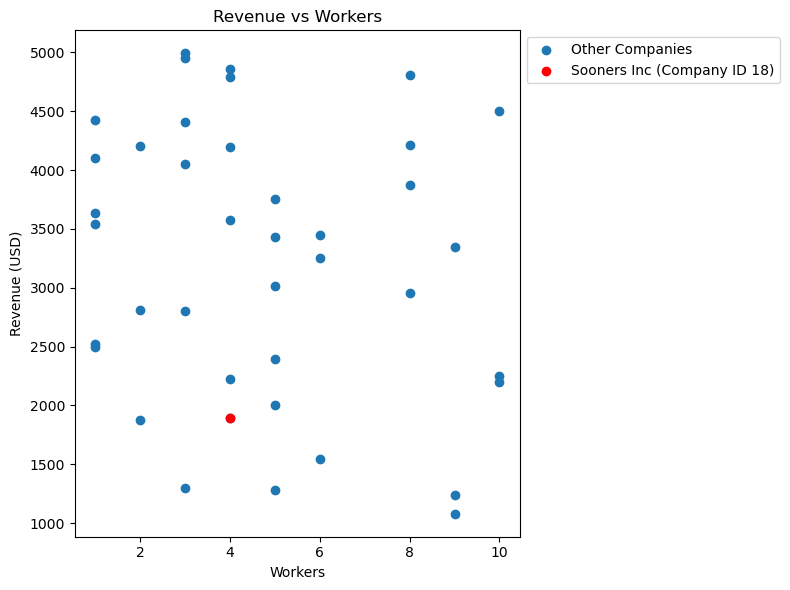

In [11]:
# Plot revenue vs workers
plt.figure(figsize=(8, 6))
plt.scatter(inputs_outputs['Workers'], inputs_outputs['Revenue USD'], label='Other Companies')
plt.scatter(sooners_inc['Workers'], sooners_inc['Revenue USD'], color='red', label='Sooners Inc (Company ID 18)')
plt.title('Revenue vs Workers')
plt.xlabel('Workers')
plt.ylabel('Revenue (USD)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

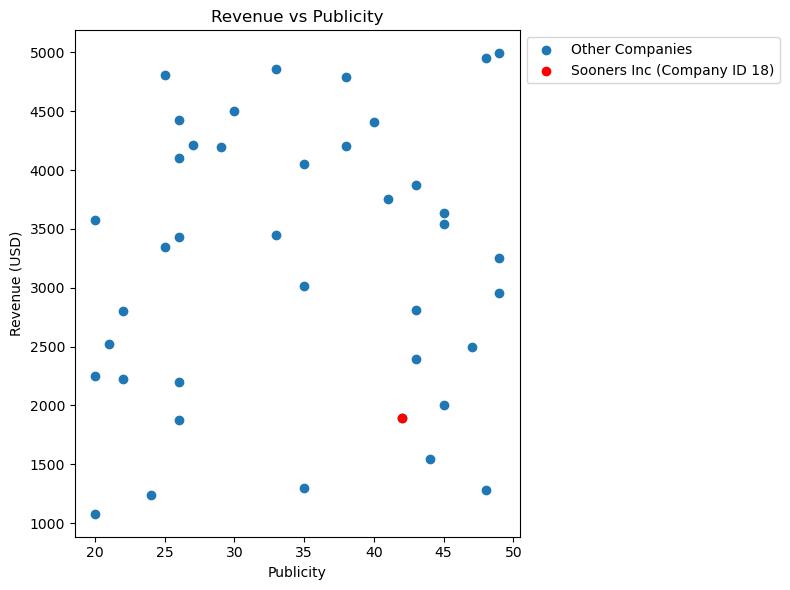

In [13]:
# Plot revenue vs publicity
plt.figure(figsize=(8, 6))
plt.scatter(inputs_outputs['Publicity'], inputs_outputs['Revenue USD'], label='Other Companies')
plt.scatter(sooners_inc['Publicity'], sooners_inc['Revenue USD'], color='red', label='Sooners Inc (Company ID 18)')
plt.title('Revenue vs Publicity')
plt.xlabel('Publicity')
plt.ylabel('Revenue (USD)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

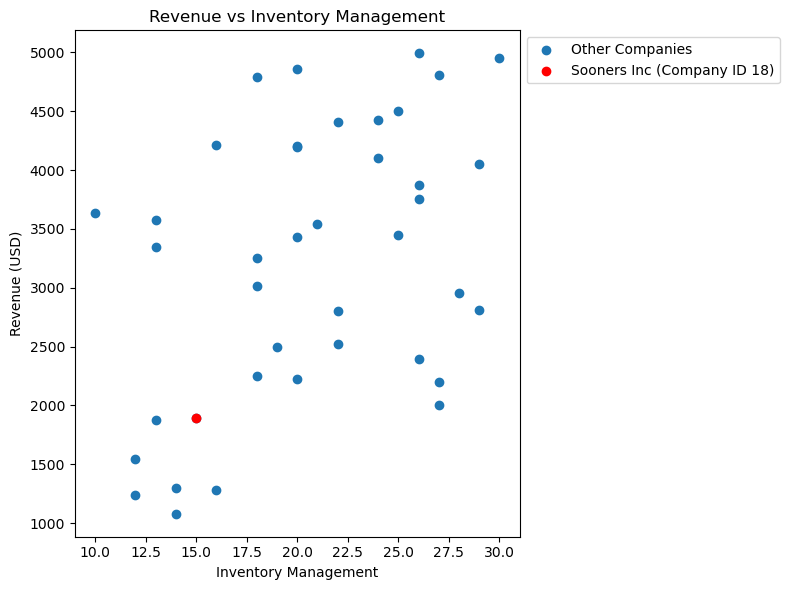

In [15]:

# Plot revenue vs inventory management
plt.figure(figsize=(8, 6))
plt.scatter(inputs_outputs['Inventory Management'], inputs_outputs['Revenue USD'], label='Other Companies')
plt.scatter(sooners_inc['Inventory Management'], sooners_inc['Revenue USD'], color='red', label='Sooners Inc (Company ID 18)')
plt.title('Revenue vs Inventory Management')
plt.xlabel('Inventory Management')
plt.ylabel('Revenue (USD)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# 1.b

In [17]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd

# Extract inputs and outputs
inputs = df[['Workers', 'Publicity', 'Inventory Management']].values
output = df['Revenue USD'].values

# Number of companies
n_companies = df.shape[0]

# Company ID 18 corresponds to index 17 (Python uses zero-indexing)
target_company = 17

# Create a Gurobi model
model = gp.Model('Sooners Inc. DEA')

# Add decision variables for lambda (one for each company) and phi (efficiency score)
lambda_vars = model.addVars(n_companies, lb=0, name="lambda")
phi = model.addVar(lb=0, name="phi")

# Set the objective: Maximize phi
model.setObjective(phi, GRB.MAXIMIZE)


for i in range(3):  # Loop over each input type
    total_input = 0  # Start with a total of 0 for the weighted inputs from all companies
    for j in range(n_companies):  # Loop over each company
        total_input += lambda_vars[j] * inputs[j, i]  # Add the weighted input from each company
    model.addConstr(total_input <= inputs[target_company, i])  # Make sure the total input doesn't exceed the target company's input

# Add output constraint (Revenue)
model.addConstr(gp.quicksum(lambda_vars[j] * output[j] for j in range(n_companies)) >= phi * output[target_company])

# Add convexity constraint: sum of lambda variables must be equal to 1
model.addConstr(gp.quicksum(lambda_vars[j] for j in range(n_companies)) == 1)

# Optimize the model
model.optimize()

# Check the optimization result
if model.status == GRB.OPTIMAL:
    print(f"Optimal phi (Efficiency Score) for Sooners Inc: {phi.X}")
    for j in range(n_companies):
        print(f"Lambda_{j+1}: {lambda_vars[j].X}")
else:
    print("No optimal solution found")

# Interpret the results
if phi.X == 1:
    print("Sooners Inc. is efficient.")
else:
    print("Sooners Inc. is inefficient.")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-19
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5 rows, 41 columns and 201 nonzeros
Model fingerprint: 0x857f8938
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+01]
Presolve removed 1 rows and 2 columns
Presolve time: 0.01s
Presolved: 4 rows, 39 columns, 156 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.6356917e+00   5.622000e+00   0.000000e+00      0s
       3    2.3001584e+00   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.300158395e+00
Optimal phi (Efficiency Score) for Sooners Inc: 2.300158394931362
Lambda_1: 0.0
Lambda_2:

# 1.c

## i.

### with slacks

In [51]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd

# Extract inputs and outputs
inputs = df[['Workers', 'Publicity', 'Inventory Management']].values
output = df['Revenue USD'].values

# Number of companies
n_companies = df.shape[0]

# Company ID 18 corresponds to index 17 (Python uses zero-indexing)
target_company = 17

# Create a Gurobi model
model = gp.Model('Sooners Inc. DEA with Slacks')

# Add decision variables for lambda (one for each company) and phi (efficiency score)
lambda_vars = model.addVars(n_companies, lb=0, name="lambda")
phi = model.addVar(lb=0, name="phi")

# Slack variables for inputs (workers, publicity, inventory management) and output (revenue)
slack_workers = model.addVar(lb=0, name="slack_workers")
slack_publicity = model.addVar(lb=0, name="slack_publicity")
slack_inventory = model.addVar(lb=0, name="slack_inventory")
slack_output = model.addVar(lb=0, name="slack_output")

# Set the objective: Maximize phi (efficiency score)
model.setObjective(phi, GRB.MAXIMIZE)

# Add input constraints for each input type (Workers, Publicity, Inventory Management) with slacks
for i in range(3):
    total_input = 0  # Start with a total of 0 for the weighted inputs from all companies
    for j in range(n_companies):
        total_input += lambda_vars[j] * inputs[j, i]  # Add the weighted input from each company
    
    # Add slack variables to input constraints
    if i == 0:
        model.addConstr(total_input + slack_workers == inputs[target_company, i])  # Workers constraint with slack
    elif i == 1:
        model.addConstr(total_input + slack_publicity == inputs[target_company, i])  # Publicity constraint with slack
    elif i == 2:
        model.addConstr(total_input + slack_inventory == inputs[target_company, i])  # Inventory constraint with slack

# Add the output constraint (Revenue) with slack
model.addConstr(gp.quicksum(lambda_vars[j] * output[j] for j in range(n_companies)) - slack_output >= phi * output[target_company])

# Add convexity constraint: sum of lambda variables must be equal to 1
model.addConstr(gp.quicksum(lambda_vars[j] for j in range(n_companies)) == 1)

# Optimize the model
model.optimize()

# Check the optimization result
if model.status == GRB.OPTIMAL:
    print(f"Optimal phi (Efficiency Score) for Sooners Inc: {phi.X}")
    for j in range(n_companies):
        print(f"Lambda_{j+1}: {lambda_vars[j].X}")

    # Print slack values
    print(f"Slack in workers: {slack_workers.X}")
    print(f"Slack in publicity: {slack_publicity.X}")
    print(f"Slack in inventory management: {slack_inventory.X}")
    print(f"Slack in output (revenue shortfall): {slack_output.X}")
else:
    print("No optimal solution found")

# Interpret the results
if phi.X == 1:
    print("Sooners Inc. is efficient.")
else:
    print("Sooners Inc. is inefficient.")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5 rows, 45 columns and 205 nonzeros
Model fingerprint: 0x4825a519
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+01]
Presolve removed 1 rows and 6 columns
Presolve time: 0.01s
Presolved: 4 rows, 39 columns, 156 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.6356917e+00   5.622000e+00   0.000000e+00      0s
       3    2.3001584e+00   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.300158395e+00
Optimal phi (Efficiency Score) for Sooners Inc: 2.300158394931362
Lambda_1: 0.0
Lambda_2: 0.0
Lambda_3: 0.0
Lambda_4: 0.0
Lambda_5: 0.0
Lambda_6: 0.0
Lambda_7: 0.0
Lambda_8: 0.0
La

# ii

# maximizing slacks

In [19]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd

# Assuming df is the dataframe already loaded
# Extract relevant columns
workers = df['Workers'].values
publicity = df['Publicity'].values
inventory_management = df['Inventory Management'].values
revenue = df['Revenue USD'].values

n_companies = len(workers)  # Number of companies
target_company = 17  # Sooners Inc. (Company ID 18)

# Create a Gurobi model
model = gp.Model('DEA_Output_Oriented_With_Slacks')

# Add decision variables for lambda (one for each company) and phi (scaling factor for revenue)
lambda_vars = model.addVars(n_companies, lb=0, name="lambda")
phi = model.addVar(lb=0, name="phi")  # This will be the scaling factor for revenue

# Slack variables for outputs (revenue) and inputs (workers, publicity, inventory management)
slack_output = model.addVar(lb=0, name="slack_output")  # Revenue shortfall
slack_workers = model.addVar(lb=0, name="slack_workers")  # Workers excess
slack_publicity = model.addVar(lb=0, name="slack_publicity")  # Publicity excess
slack_inventory = model.addVar(lb=0, name="slack_inventory")  # Inventory excess

# Set the objective: Maximize the sum of slacks (both inputs and outputs)
model.setObjective(slack_output + slack_workers + slack_publicity + slack_inventory, GRB.MAXIMIZE)

# Add the output constraint (revenue)
model.addConstr(gp.quicksum(lambda_vars[j] * revenue[j] for j in range(n_companies)) - slack_output == phi * revenue[target_company])

# Add input constraints with slack variables for workers, publicity, and inventory management
model.addConstr(gp.quicksum(lambda_vars[j] * workers[j] for j in range(n_companies)) + slack_workers == workers[target_company])
model.addConstr(gp.quicksum(lambda_vars[j] * publicity[j] for j in range(n_companies)) + slack_publicity == publicity[target_company])
model.addConstr(gp.quicksum(lambda_vars[j] * inventory_management[j] for j in range(n_companies)) + slack_inventory == inventory_management[target_company])

# Add convexity constraint (sum of lambda variables must be 1)
model.addConstr(gp.quicksum(lambda_vars[j] for j in range(n_companies)) == 1)

# Optimize the model
model.optimize()

# Display results
if model.status == GRB.OPTIMAL:
    print(f"Optimal phi (Growth factor for revenue): {phi.X}")
    for j in range(n_companies):
        print(f"Lambda_{j+1}: {lambda_vars[j].X}")
    
    # Display the slack variables
    print(f"Slack in output (revenue shortfall): {slack_output.X}")
    print(f"Slack in workers: {slack_workers.X}")
    print(f"Slack in publicity: {slack_publicity.X}")
    print(f"Slack in inventory management: {slack_inventory.X}")
else:
    print("No optimal solution found.")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5 rows, 45 columns and 205 nonzeros
Model fingerprint: 0xef964718
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+01]
Presolve removed 1 rows and 3 columns
Presolve time: 0.00s
Presolved: 4 rows, 42 columns, 159 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0530640e+03   1.350562e+01   0.000000e+00      0s
       8    4.3590000e+03   0.000000e+00   0.000000e+00      0s

Solved in 8 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.359000000e+03
Optimal phi (Growth factor for revenue): 0.0
Lambda_1: 0.0
Lambda_2: 0.0
Lambda_3: 0.0
Lambda_4: 0.0
Lambda_5: 0.0
Lambda_6: 0.0
Lambda_7: 0.0
Lambda_8: 0.0
Lambda_9: 0.0
Lambda_10

# minimizing resources with the same revenue

In [47]:
# Extract relevant columns
workers = df['Workers'].values
publicity = df['Publicity'].values
inventory_management = df['Inventory Management'].values
revenue = df['Revenue USD'].values

n_companies = len(workers)  # Number of companies
target_company = 17  # Sooners Inc. (Company ID 18)

# Create a Gurobi model
model = gp.Model('DEA_Input_Oriented_Resource_Allocation')

# Add decision variables for lambda (one for each company) and theta (scaling factor for inputs)
lambda_vars = model.addVars(n_companies, lb=0, name="lambda")
theta = model.addVar(lb=0, name="theta")  # This will be the scaling factor for input reduction

# Set the objective: Minimize theta (input reduction factor)
model.setObjective(theta, GRB.MINIMIZE)

# Add the output constraint (revenue is fixed and should be equal to the target company's revenue)
model.addConstr(gp.quicksum(lambda_vars[j] * revenue[j] for j in range(n_companies)) >= revenue[target_company])

# Add input constraints with scaling factor theta
# For workers
model.addConstr(gp.quicksum(lambda_vars[j] * workers[j] for j in range(n_companies)) <= theta * workers[target_company])

# For publicity
model.addConstr(gp.quicksum(lambda_vars[j] * publicity[j] for j in range(n_companies)) <= theta * publicity[target_company])

# For inventory management
model.addConstr(gp.quicksum(lambda_vars[j] * inventory_management[j] for j in range(n_companies)) <= theta * inventory_management[target_company])

# Add convexity constraint (sum of lambda variables must be 1)
model.addConstr(gp.quicksum(lambda_vars[j] for j in range(n_companies)) == 1)

# Optimize the model
model.optimize()

# Display results
if model.status == GRB.OPTIMAL:
    print(f"Optimal theta (Scaling factor for input reduction): {theta.X}")
    for j in range(n_companies):
        print(f"Lambda_{j+1}: {lambda_vars[j].X}")

    # Calculate new input levels
    new_workers = theta.X * workers[target_company]
    new_publicity = theta.X * publicity[target_company]
    new_inventory_management = theta.X * inventory_management[target_company]

    print(f"New Workers Level: {new_workers}")
    print(f"New Publicity Level: {new_publicity}")
    print(f"New Inventory Management Level: {new_inventory_management}")
else:
    print("No optimal solution found.")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5 rows, 41 columns and 203 nonzeros
Model fingerprint: 0x0d84e741
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+03]
Presolve time: 0.00s
Presolved: 5 rows, 41 columns, 203 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.725000e+01   0.000000e+00      0s
       4    7.6597974e-01   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds (0.00 work units)
Optimal objective  7.659797415e-01
Optimal theta (Scaling factor for input reduction): 0.7659797415298638
Lambda_1: 0.0
Lambda_2: 0.0
Lambda_3: 0.09570380719524973
Lambda_4: 0.0
Lambda_5: 0.0
Lambda_6: 0.0
Lambda_7: 0.0
Lambda_8: 0.0
Lambda_9: 0.0
Lambd

# 1.d

In [57]:
import gurobipy as gp
from gurobipy import GRB

# Assuming df is the dataframe already loaded with inputs and outputs
inputs = df[['Workers', 'Publicity', 'Inventory Management']].values
output = df['Revenue USD'].values
cash_proportion = df['Cash USD'].values

n_companies = len(inputs)  # Number of companies
target_company = 17  # Sooners Inc. (Company ID 18)

# Create a Gurobi model
model = gp.Model('Minimize Cash Proportion')

# Add decision variables for lambda (one for each company)
lambda_vars = model.addVars(n_companies, lb=0, name="lambda")

# Add a variable for the cash proportion of the target company
cash_var = model.addVar(lb=0, name="cash_proportion")

# Set the objective to minimize the cash proportion of the target company
model.setObjective(cash_var, GRB.MINIMIZE)

# Add the cash constraint (ensure total cash is within the proportion of company 18)
model.addConstr(gp.quicksum(lambda_vars[j] * cash_proportion[j] for j in range(n_companies)) <= cash_proportion[target_company] * cash_var)

# Add input constraints (workers, publicity, inventory management)
for i in range(3):  # Loop over each input type
    total_input = gp.quicksum(lambda_vars[j] * inputs[j, i] for j in range(n_companies))
    model.addConstr(total_input <= inputs[target_company, i])

# Add the output constraint (revenue must be at least 2.3 times company 18's revenue)
model.addConstr(gp.quicksum(lambda_vars[j] * output[j] for j in range(n_companies)) >= 2.3 * output[target_company])

# Add the convexity constraint (sum of lambda variables must be equal to 1)
model.addConstr(gp.quicksum(lambda_vars[j] for j in range(n_companies)) == 1)

# Optimize the model
model.optimize()

# Check the optimization result
if model.status == GRB.OPTIMAL:
    print(f"Optimal cash proportion: {cash_var.X}")
    for j in range(n_companies):
        print(f"Lambda_{j+1}: {lambda_vars[j].X}")
else:
    print("No optimal solution found.")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 6 rows, 41 columns and 241 nonzeros
Model fingerprint: 0x6d53c393
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 1 rows and 1 columns
Presolve time: 0.01s
Presolved: 5 rows, 40 columns, 200 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.1902246e-02   1.220625e+01   0.000000e+00      0s
       2    3.7318656e-01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.731865581e-01
Optimal cash proportion: 0.37318655808343554
Lambda_1: 0.0
Lambda_2: 0.0
Lambda_3: 0.0
Lambda_4: 0.0
Lambda_5: 0.0
Lambda_6: 0.0
Lambda_7: 0.0
Lambda_8: 0.0
Lambda_9: 0.0
Lambda_10

# 2.a 

In [148]:
import gurobipy as gp
from gurobipy import GRB

# Data
factories = ['A', 'B', 'C', 'D']
customers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
demand = {1: 97, 2: 24, 3: 19, 4: 17, 5: 64, 6: 73, 7: 19, 8: 98, 9: 87, 
          10: 79, 11: 17, 12: 72, 13: 39, 14: 96, 15: 53}  # Demand for each customer

# Transportation cost matrix
cost = {
    ('A', 1): 5, ('A', 2): 6, ('A', 3): 4, ('A', 4): 2, ('A', 5): 5, ('A', 6): 2, 
    ('A', 7): 1, ('A', 8): 9, ('A', 9): 7, ('A', 10): 10, ('A', 11): 5, ('A', 12): 2, 
    ('A', 13): 6, ('A', 14): 4, ('A', 15): 2,
    ('B', 1): 2, ('B', 2): 6, ('B', 3): 6, ('B', 4): 2, ('B', 5): 7, ('B', 6): 1, 
    ('B', 7): 4, ('B', 8): 10, ('B', 9): 9, ('B', 10): 1, ('B', 11): 4, ('B', 12): 10, 
    ('B', 13): 3, ('B', 14): 7, ('B', 15): 3,
    ('C', 1): 3, ('C', 2): 5, ('C', 3): 5, ('C', 4): 8, ('C', 5): 7, ('C', 6): 7, 
    ('C', 7): 3, ('C', 8): 9, ('C', 9): 8, ('C', 10): 5, ('C', 11): 6, ('C', 12): 10, 
    ('C', 13): 3, ('C', 14): 7, ('C', 15): 4,
    ('D', 1): 4, ('D', 2): 6, ('D', 3): 1, ('D', 4): 3, ('D', 5): 10, ('D', 6): 5, 
    ('D', 7): 4, ('D', 8): 9, ('D', 9): 6, ('D', 10): 8, ('D', 11): 4, ('D', 12): 8, 
    ('D', 13): 8, ('D', 14): 2, ('D', 15): 5
}

# Create Gurobi model
model = gp.Model("Minimum Cost Flow with Unlimited Supply")

# Decision variables: flow from factory i to customer j
x = model.addVars(factories, customers, lb=0, name="x")

# Objective: Minimize transportation cost
model.setObjective(gp.quicksum(cost[i,j] * x[i,j] for i in factories for j in customers), GRB.MINIMIZE)

# Flow balance constraints for customers (demand must be fully met)
for j in customers:
    model.addConstr(gp.quicksum(x[i,j] for i in factories) == demand[j], f"Demand_{j}")

# Optimize the model
model.optimize()

# Print the results
if model.status == GRB.OPTIMAL:
    print(f"Optimal objective value (minimum transportation cost): {model.objVal}")
    for i in factories:
        for j in customers:
            if x[i,j].X > 0:
                print(f"Ship {x[i,j].X} cans from {i} to Customer {j}")
else:
    print("No optimal solution found")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 15 rows, 60 columns and 60 nonzeros
Model fingerprint: 0x153a34e8
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 1e+02]
Presolve removed 15 rows and 60 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8890000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.889000000e+03
Optimal objective value (minimum transportation cost): 2889.0
Ship 64.0 cans from A to Customer 5
Ship 19.0 cans from A to Customer 7
Ship 98.0 cans from A to Customer 8
Ship 72.0 cans from A to Customer 12
Ship 53.0 cans from A to Customer 15
Ship

# 2.b

In [145]:
import gurobipy as gp
from gurobipy import GRB

# Data
factories = ['A', 'B', 'C', 'D']
customers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
supply = {'A': 100, 'B': 200, 'C': 150, 'D': 175}  # Supply for each factory
demand = {1: 97, 2: 24, 3: 19, 4: 17, 5: 64, 6: 73, 7: 19, 8: 98, 9: 87, 
          10: 79, 11: 17, 12: 72, 13: 39, 14: 96, 15: 53}  # Demand for each customer

# Cost of undelivered units for each customer
undelivered_cost = {1: 100, 2: 100, 3: 100, 4: 100, 5: 500, 6: 100, 7: 100, 8: 100, 
                    9: 100, 10: 800, 11: 300, 12: 100, 13: 100, 14: 100, 15: 100}

# Transportation cost matrix
cost = {
    ('A', 1): 5, ('A', 2): 6, ('A', 3): 4, ('A', 4): 2, ('A', 5): 5, ('A', 6): 2, 
    ('A', 7): 1, ('A', 8): 9, ('A', 9): 7, ('A', 10): 10, ('A', 11): 5, ('A', 12): 2, 
    ('A', 13): 6, ('A', 14): 4, ('A', 15): 2,
    ('B', 1): 2, ('B', 2): 6, ('B', 3): 6, ('B', 4): 2, ('B', 5): 7, ('B', 6): 1, 
    ('B', 7): 4, ('B', 8): 10, ('B', 9): 9, ('B', 10): 1, ('B', 11): 4, ('B', 12): 10, 
    ('B', 13): 3, ('B', 14): 7, ('B', 15): 3,
    ('C', 1): 3, ('C', 2): 5, ('C', 3): 5, ('C', 4): 8, ('C', 5): 7, ('C', 6): 7, 
    ('C', 7): 3, ('C', 8): 9, ('C', 9): 8, ('C', 10): 5, ('C', 11): 6, ('C', 12): 10, 
    ('C', 13): 3, ('C', 14): 7, ('C', 15): 4,
    ('D', 1): 4, ('D', 2): 6, ('D', 3): 1, ('D', 4): 3, ('D', 5): 10, ('D', 6): 5, 
    ('D', 7): 4, ('D', 8): 9, ('D', 9): 6, ('D', 10): 8, ('D', 11): 4, ('D', 12): 8, 
    ('D', 13): 8, ('D', 14): 2, ('D', 15): 5
}

# Create Gurobi model
model = gp.Model("Minimum Cost Flow with Undelivered Units")

# Decision variables: flow from factory i to customer j
x = model.addVars(factories, customers, lb=0, name="x")

# Decision variables: undelivered units for each customer
z = model.addVars(customers, lb=0, name="z")

# Objective: Minimize transportation cost + cost of undelivered units
model.setObjective(gp.quicksum(cost[i,j] * x[i,j] for i in factories for j in customers) +
                   gp.quicksum(undelivered_cost[j] * z[j] for j in customers), GRB.MINIMIZE)

# Flow balance constraints for factories (supply)
for i in factories:
    model.addConstr(gp.quicksum(x[i,j] for j in customers) <= supply[i], f"Supply_{i}")

# Flow balance constraints for customers (demand)
for j in customers:
    model.addConstr(gp.quicksum(x[i,j] for i in factories) + z[j] == demand[j], f"Demand_{j}")

# Optimize the model
model.optimize()

# Print the results
if model.status == GRB.OPTIMAL:
    print(f"Optimal objective value (minimum cost): {model.objVal}")
    for i in factories:
        for j in customers:
            if x[i,j].X > 0:
                print(f"Ship {x[i,j].X} cans from {i} to Customer {j}")
    for j in customers:
        if z[j].X > 0:
            print(f"Customer {j} has {z[j].X} undelivered units, with penalty cost.")
else:
    print("No optimal solution found")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 19 rows, 75 columns and 135 nonzeros
Model fingerprint: 0xeba3f1ca
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 8e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 2e+02]
Presolve time: 0.00s
Presolved: 19 rows, 75 columns, 135 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8890000e+03   3.550000e+02   0.000000e+00      0s
      16    2.4493000e+04   0.000000e+00   0.000000e+00      0s

Solved in 16 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.449300000e+04
Optimal objective value (minimum cost): 24493.0
Ship 52.0 cans from A to Customer 12
Ship 48.0 cans from A to Customer 15
Ship 43.0 cans from B to Customer 1
Ship 73.0 cans from B to Customer 6
Ship 79.0 cans from B